<a href="https://colab.research.google.com/github/Anshuman-02905/URBAN_MONITORING_SYSTEM/blob/main/DATA_PREPARATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import glob
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import shutil
from tqdm import tqdm
import random

In [ ]:
root="D:/PROJECT/DATAPREPARATION/DATASET/TEST/"

image=root+"Sentinel_png/"
annotation=root+"Mask_png/"

correct_mask=root+"correct_mask/"
patch=root+"256_patches/"

final_image=root+"256_patches/images/"
final_mask=root+"256_patches/masks/"
data=root+"256_patches/DATA/"
images_prepped_train=root+"256_patches/DATA/images_prepped_train/"
images_prepped_test=root+"256_patches/DATA/images_prepped_test/"
annotations_prepped_train=root+"256_patches/DATA/annotations_prepped_train/"
annotations_prepped_test=root+"256_patches/DATA/annotations_prepped_test/"
ls=[image,annotation,correct_mask,patch,final_image,final_mask,data,images_prepped_train,images_prepped_test,annotations_prepped_train,annotations_prepped_test]
for i in ls:
    if(not(os.path.exists(i))):
        print(i+" Directory not present")
        os.mkdir(i)

In [ ]:
def convert_label(annotation,correct_mask):
    for path , dirs,files in os.walk(annotation):
        for i in tqdm(files):
            im=cv2.imread(annotation+i,cv2.IMREAD_UNCHANGED)
            for k in range(0,len(im)):
                 for j in range(0,len(im[k])):
                     if(im[k][j]==255):
                         im[k][j]=1
            cv2.imwrite(correct_mask+i, im)
#convert_label(annotation,correct_mask)

In [ ]:
def Create_patches(image,correct_mask,final_image,final_mask):
    patch_size = 256
    c=0
    for path, subdirs, files in os.walk(image):
        #print(path)  
        dirname = path.split(os.path.sep)[-1]
        #print(dirname)
        images = os.listdir(path)  #List of all image names in this subdirectory
        #print(images)
        for i, image_name in enumerate(images):  
            if image_name.endswith(".png"):
                #print(image_name)
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)   
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (256, 256, 3), step=256)  #Step=256 for 256 patches means no over
            
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                    
                        single_patch_img = patches_img[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #We will preprocess using one of the backbones
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                    
                        cv2.imwrite(final_image+str(c)+".png", single_patch_img)
                        c+=1
                        #image_dataset.append(single_patch_img)
    c=0
    for path, subdirs, files in os.walk(correct_mask):
        #print(path)  
        dirname = path.split(os.path.sep)[-1]
        print(dirname)
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):           
                mask = cv2.imread(path+"/"+mask_name, 0)  #Read each image as Grey (or color but remember to map each color to an integer)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
   
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                    
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        #single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        cv2.imwrite(final_mask+str(c)+".png", single_patch_mask)
                        c+=1
#Create_patches(image,correct_mask,final_image,final_mask)

In [ ]:
#TEST
def test(final_image,final_mask):
    train_img_dir = final_image
    train_mask_dir = final_mask

    img_list = os.listdir(final_image)
    msk_list = os.listdir(final_mask)

    num_images = len(os.listdir(train_img_dir))

    img_num = random.randint(0, num_images-1)
    print(img_num)
    img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
    img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

    mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

    plt.figure(figsize=(12, 8))
    plt.subplot(121)
    plt.imshow(img_for_plot)
    plt.title('Image')
    plt.subplot(122)
    plt.imshow(mask_for_plot, cmap='gray')
    plt.title('Mask')
    plt.show()
#test(final_image,final_mask)

In [ ]:
#Train Test Split
def test_train_split(length,ratio,final_image,final_mask,images_prepped_train,annotations_prepped_train,images_prepped_test,annotations_prepped_test,sed=0):
    random.seed(sed)
    st = list(range(0,length))
    random.shuffle(st)
    brk=int(ratio*length)
    train=st[0:brk]
    test=st[brk:length]
  
    for i in tqdm(train):
        src_image_tr=final_image+str(i)+".png"
        src_annote_tr=final_mask+str(i)+".png"
        dst_image_tr=images_prepped_train+str(i)+".png"
        dst_annote_tr=annotations_prepped_train+str(i)+".png"
        shutil.copyfile(src_image_tr,dst_image_tr)
        shutil.copyfile(src_annote_tr,dst_annote_tr)
    for i in tqdm(test):
        src_image=final_image+str(i)+".png"
        src_annote=final_mask+str(i)+".png"
        dst_image=images_prepped_test+str(i)+".png"
        dst_annote=annotations_prepped_test+str(i)+".png"
        shutil.copyfile(src_image,dst_image)
        shutil.copyfile(src_annote,dst_annote)


    return test,train
num_images = len(os.listdir(final_image))
#test,train=test_train_split(num_images,0.75,final_image,final_mask,images_prepped_train,annotations_prepped_train,images_prepped_test,annotations_prepped_test)

100%|██████████| 26/26 [00:57<00:00,  2.20s/it]


Now patchifying image: D:/PROJECT/DATAPREPARATION/DATASET/TEST/Sentinel_png//0.png
Now patchifying image: D:/PROJECT/DATAPREPARATION/DATASET/TEST/Sentinel_png//1.png
Now patchifying image: D:/PROJECT/DATAPREPARATION/DATASET/TEST/Sentinel_png//10.png
Now patchifying image: D:/PROJECT/DATAPREPARATION/DATASET/TEST/Sentinel_png//11.png
Now patchifying image: D:/PROJECT/DATAPREPARATION/DATASET/TEST/Sentinel_png//12.png
Now patchifying image: D:/PROJECT/DATAPREPARATION/DATASET/TEST/Sentinel_png//13.png
Now patchifying image: D:/PROJECT/DATAPREPARATION/DATASET/TEST/Sentinel_png//14.png
Now patchifying image: D:/PROJECT/DATAPREPARATION/DATASET/TEST/Sentinel_png//15.png
Now patchifying image: D:/PROJECT/DATAPREPARATION/DATASET/TEST/Sentinel_png//16.png
Now patchifying image: D:/PROJECT/DATAPREPARATION/DATASET/TEST/Sentinel_png//17.png
Now patchifying image: D:/PROJECT/DATAPREPARATION/DATASET/TEST/Sentinel_png//18.png
Now patchifying image: D:/PROJECT/DATAPREPARATION/DATASET/TEST/Sentinel_png//1

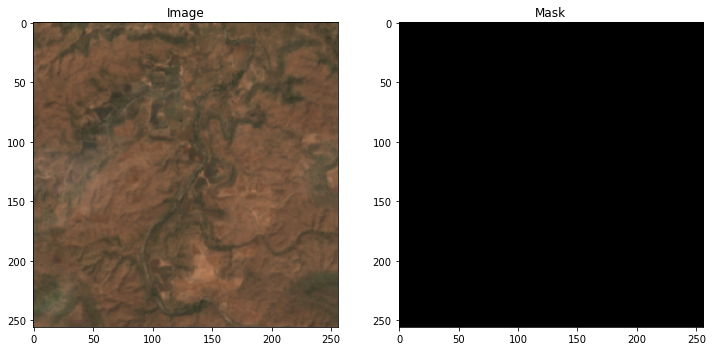

100%|██████████| 156/156 [00:00<00:00, 1228.34it/s]


In [ ]:
convert_label(annotation,correct_mask)
Create_patches(image,correct_mask,final_image,final_mask)
test(final_image,final_mask)
number_images = len(os.listdir(final_image))
test,train=test_train_split(number_images,0.75,final_image,final_mask,images_prepped_train,annotations_prepped_train,images_prepped_test,annotations_prepped_test)

D:/PROJECT/DATAPREPARATION/DATASET/TEST/256_patches/masks/
